# Taitanic 생존 예측

### KNN 분류
### Logistic 회귀 분류
### 결정트리 분류

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

titanic = sns.load_dataset('titanic')

In [2]:
titanic.info()
titanic.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [3]:
# 1. 결측치 처리부터.. age는 knn대체, embarked최빈값 대체 / deck, alive 컬럼 삭제
# 2. 범주형 -> 수치형으로 변환 (sex, class)
# 3. 스케일링
# 4. knn분류, 로지스틱회귀, 결정트리

In [4]:
# 1. 범주형부터 수치형으로 변환

# 성별 male=0, female=1
titanic['sex'] = titanic['sex'].str.strip().str.lower()
titanic['sex'] = titanic['sex'].map({'male':0, 'female':1})

# class: First=1, Second=2, Third=3
titanic['class'] = titanic['class'].str.strip()
titanic['class'] = titanic['class'].map({'First':1, 'Second':2, 'Third':3})

titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,0,22.0,1,0,7.2500,S,3,man,True,NaN,Southampton,no,False
1,1,1,1,38.0,1,0,71.2833,C,1,woman,False,C,Cherbourg,yes,False
2,1,3,1,26.0,0,0,7.9250,S,3,woman,False,NaN,Southampton,yes,True
3,1,1,1,35.0,1,0,53.1000,S,1,woman,False,C,Southampton,yes,False
4,0,3,0,35.0,0,0,8.0500,S,3,man,True,NaN,Southampton,no,True


In [70]:
# embarked는 어떻게 처리할래?


# 실험실에서 기능 활성화
from sklearn.experimental import enable_iterative_imputer
# MICE (다른 특성으로 결측 대체하기)
from sklearn.impute import IterativeImputer

features = ['pclass', 'sex', 'age', 'fare', 'embarked']
target = 'survived'

df = titanic[features + [target]]

# One-Hot Encoding (OHE) -> 범주형 데이터를 T/F로 이루어진 여러개의 컬럼으로 변환
# Pros -> 숫자 0, 1, 2 는 크기 순서가 생겨 해석이 잘못될 수 있음
# Cons -> 카테고리가 많으면 차원이 늘어남
df = pd.get_dummies(df, columns=['sex', 'embarked'])


# 결측치가 있는 변수를 다른 변수들을 이용해 반복적으로 예측 (MICE)
imputer = IterativeImputer(
    max_iter=10,
    random_state=42
)

df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df_imputed.head()

# encoder = OneHotEncoder(sparse_output=False, drop=None)
# df_encoded = pd.DataFrame(encoder.fit_transform(df[['sex', 'embarked']]), columns=df.columns)

,pclass,age,fare,survived,sex_0.0,sex_1.0,embarked_C,embarked_Q,embarked_S
0,3.0,22.0,7.2500,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,38.0,71.2833,1.0,0.0,1.0,1.0,0.0,0.0
2,3.0,26.0,7.9250,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,35.0,53.1000,1.0,0.0,1.0,0.0,0.0,1.0
4,3.0,35.0,8.0500,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
from sklearn.impute import KNNImputer

# 2. 결측치 처리

# 2-1. 나이 knn으로..
cols = ['pclass', 'sex', 'sibsp', 'parch', 'fare', 'age']

imputer = KNNImputer(n_neighbors=5)

# fit_transform 후 DataFrame으로 변환, 인덱스와 컬럼명 유지
titanic[cols] = pd.DataFrame(
    imputer.fit_transform(titanic[cols]),
    columns=cols,
    index=titanic.index
)

# 2-2. embarked는 최빈값으로 대체
titanic['embarked'].value_counts() # 확인하고 값 넣어주기
titanic['embarked'] = titanic['embarked'].fillna('S')  

# # 이런 방법도 있음
most_freq = titanic['embarked'].mode()[0]  # 최빈값 추출
titanic['embarked'] = titanic['embarked'].fillna(most_freq)

In [15]:
titanic.isna().mean()*100

survived        0.000000
pclass          0.000000
sex             0.000000
age             0.000000
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.000000
class           0.000000
who             0.000000
adult_male      0.000000
deck           77.216611
embark_town     0.224467
alive           0.000000
alone           0.000000
dtype: float64

deck,A,B,C,D,E,F,G
pclass,,,,,,,
1.0,8.571429,26.857143,33.714286,16.571429,14.285714,0.000000,0.000000
2.0,0.000000,0.000000,0.000000,25.000000,25.000000,50.000000,0.000000
3.0,0.000000,0.000000,0.000000,0.000000,25.000000,41.666667,33.333333


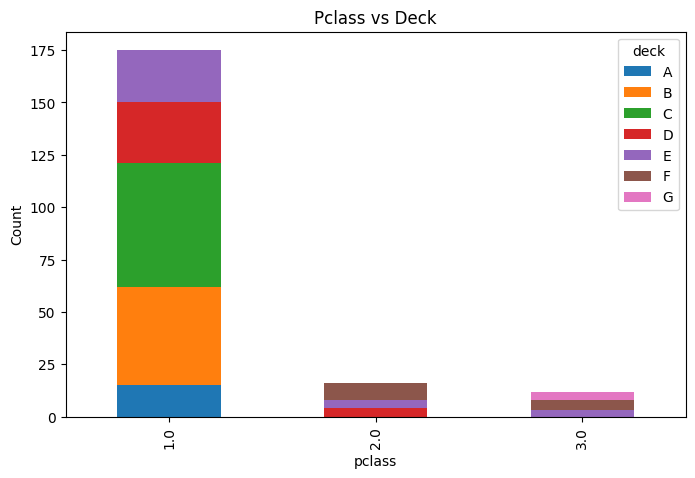

In [ ]:
# deck.. 고민.... 결측이 70퍼센트 이상이면 삭제하는게 낫다는데
display(pd.crosstab(titanic['pclass'], titanic['deck'], normalize='index') * 100)

# 시각화
ct = pd.crosstab(titanic['pclass'], titanic['deck'])
ct.plot(kind='bar', stacked=True, figsize=(8,5))
plt.ylabel('Count')
plt.title('Pclass vs Deck')
plt.show()

# 1등급은 ABCDE, 2등급 DEF, 3등급 EFG 랜덥하게 채울까? 아님 그냥 삭제할까?

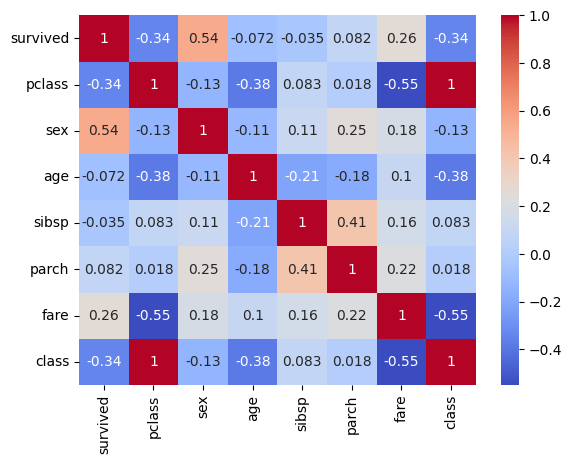

In [23]:
# 숫자형 컬럼 - 변수별 상관관계
num_cols = titanic.select_dtypes(include=['int64','float64']).columns
corr_matrix = titanic[num_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [31]:
# 3-1. 데이터 분리
X = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'alone']]
y = titanic['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# 3-2. 스케일링
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


### KNN, 로지스틱회귀, 결정트리

In [ ]:
# 4-1. knn분류
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled, y_train)

print('훈련점수: ',knn.score(X_train_scaled, y_train))
print('테스트점수: ',knn.score(X_test_scaled, y_test))


# 로지스틱회귀
lr = LogisticRegression(C=1)
lr.fit(X_train_scaled, y_train)

print('\n훈련점수: ', lr.score(X_train_scaled, y_train))
print('테스트점수: ',lr.score(X_test_scaled, y_test))


# 결정트리
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)

print('\n훈련점수: ', dt.score(X_train_scaled, y_train))
print('테스트점수: ', dt.score(X_test_scaled, y_test))


# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(y=scoree, x=['KNN', 'LR', 'DT'])


훈련점수:  0.8497191011235955
테스트점수:  0.7877094972067039

훈련점수:  0.8160112359550562
테스트점수:  0.7597765363128491

훈련점수:  0.8539325842696629
테스트점수:  0.7988826815642458


In [ ]:
# 최적의 k개를 찾아서...

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

neighbors_range = range(1, 21)  # 1~20 이웃
cv_scores = []

for k in neighbors_range:
    kn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(kn, X_train_scaled, y_train, cv=5)
    cv_scores.append(scores.mean())

best_k = neighbors_range[np.argmax(cv_scores)]
print("최적 n_neighbors:", best_k)

최적 n_neighbors: 8


In [ ]:
# 최적의 C를 찾아서...

C_range = np.logspace(-3, 3, 7)  # 0.001 ~ 1000 범위를 로그 스케일로
cv_scores = []

for c in C_range:
    lr = LogisticRegression(C=c, max_iter=1000)
    scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
    cv_scores.append(scores.mean())

best_C = C_range[np.argmax(cv_scores)]
print("최적 C:", best_C)

최적 C: 1.0


In [ ]:
# 최적의 depth를 찾아서...

from sklearn.model_selection import cross_val_score

depth_range = range(1, 11)  # 1~10 깊이 테스트
cv_scores = []


for d in depth_range:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(dt, X_train_scaled, y_train, cv=5)  # 5-fold CV
    cv_scores.append(scores.mean())

best_depth = depth_range[np.argmax(cv_scores)]
print("최적 max_depth:", best_depth)

최적 max_depth: 8
